<a href="https://colab.research.google.com/github/unes07/DRL_TradingStrategy_MarocTelecom/blob/main/MarocTelecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for IAM Stock Trading.
Using OpenAI DRL to trade single stock (Maroc Telecom Casablanca Stock Exchange).

Based on the paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.

## Python Package Installation

As a first step we check if the additional packages needed are present, if not install them. 
* pandas
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4

In [ ]:
from stockstats import StockDataFrame as Sdf

import pandas as pd
import matplotlib.pyplot as plt

import gym
from stable_baselines import PPO2, DDPG, A2C, ACKTR, TD3
from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy

In [ ]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

#DATA

In [ ]:
from google.colab import files
uploaded = files.upload()

In [223]:
import io
#df = pd.read_csv(io.BytesIO(uploaded['mtdata.csv']))
df = pd.read_csv('mtdata.csv')

In [224]:
df.head()

,Code,Codification,ExchangeCode,Libelle,Devise,Date,Ouverture,Plus haut,Plus bas,Prix,Quantité
0,IAM,TICK,XCAS,ITISSALAT AL-MAGHRIB,MAD,1/3/2005,83.52,84.46,83.52,83.81,292929.17
1,IAM,TICK,XCAS,ITISSALAT AL-MAGHRIB,MAD,1/4/2005,83.81,83.81,81.79,82.92,119242.71
2,IAM,TICK,XCAS,ITISSALAT AL-MAGHRIB,MAD,1/5/2005,83.52,83.52,81.79,83.31,154219.79
3,IAM,TICK,XCAS,ITISSALAT AL-MAGHRIB,MAD,1/6/2005,83.04,83.39,82.10,82.52,256865.62
4,IAM,TICK,XCAS,ITISSALAT AL-MAGHRIB,MAD,1/7/2005,81.60,82.08,80.64,81.60,460147.92


In [ ]:
df.shape

(4021, 12)

In [ ]:
# reset the index, we want to use numbers instead of dates
df=df.reset_index()

In [ ]:
df.head()

In [ ]:
df.columns

Index(['level_0', 'index', 'Code', 'Codification', 'ExchangeCode', 'Libelle',
       'Devise', 'Date', 'Ouverture', 'Plus haut', 'Plus bas', 'Prix',
       'Quantité'],
      dtype='object')

In [ ]:
for i in df.columns:
  if i != 'Date':
    df[i] = pd.to_numeric(df[i], errors='coerce')
  elif i == 'Date':
    df[i] = pd.to_datetime(df[i])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4021 entries, 0 to 4020
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   level_0       4021 non-null   int64         
 1   index         4021 non-null   int64         
 2   Code          0 non-null      float64       
 3   Codification  0 non-null      float64       
 4   ExchangeCode  0 non-null      float64       
 5   Libelle       0 non-null      float64       
 6   Devise        0 non-null      float64       
 7   Date          4021 non-null   datetime64[ns]
 8   Ouverture     4015 non-null   float64       
 9   Plus haut     4020 non-null   float64       
 10  Plus bas      4020 non-null   float64       
 11  Prix          4021 non-null   float64       
 12  Quantité      4016 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(2)
memory usage: 408.5 KB


In [ ]:
mt = df[['Date', 'Ouverture', 'Plus haut', 'Plus bas', 'Prix', 'Quantité']].copy()

In [ ]:
mt.columns = ['datadate','open','high','low','close','volume']

In [ ]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4021 entries, 0 to 4020
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datadate  4021 non-null   datetime64[ns]
 1   open      4015 non-null   float64       
 2   high      4020 non-null   float64       
 3   low       4020 non-null   float64       
 4   close     4021 non-null   float64       
 5   volume    4016 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 188.6 KB


In [ ]:
mt.head()

,datadate,open,high,low,close,volume
0,2005-01-03,83.52,84.46,83.52,83.81,292929.17
1,2005-01-04,83.81,83.81,81.79,82.92,119242.71
2,2005-01-05,83.52,83.52,81.79,83.31,154219.79
3,2005-01-06,83.04,83.39,82.10,82.52,256865.62
4,2005-01-07,81.60,82.08,80.64,81.60,460147.92


In [ ]:
mt.to_csv('maroctelecom.csv')

# Part 2: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.

In [ ]:
# check missing data 
mt.isnull().values.any()

True

In [ ]:
# calculate technical indicators like MACD
stock = Sdf.retype(mt.copy())
mt['macd'] = stock['macd']

In [ ]:
# check missing data again
mt.isnull().values.any()

True

In [ ]:
mt.head()

,datadate,open,high,low,close,volume,macd
0,2005-01-03,83.52,84.46,83.52,83.81,292929.17,0.000000
1,2005-01-04,83.81,83.81,81.79,82.92,119242.71,-0.019968
2,2005-01-05,83.52,83.52,81.79,83.31,154219.79,-0.013349
3,2005-01-06,83.04,83.39,82.10,82.52,256865.62,-0.038534
4,2005-01-07,81.60,82.08,80.64,81.60,460147.92,-0.088017


In [ ]:
mt=mt.fillna(method='bfill')

In [ ]:
mt.isnull().values.any()

False

In [ ]:
# Note that I always use a copy of the original data to try it track step by step.
data_clean = mt.copy()

In [ ]:
data_clean.head()

,datadate,open,high,low,close,volume,macd
0,2005-01-03,83.52,84.46,83.52,83.81,292929.17,0.000000
1,2005-01-04,83.81,83.81,81.79,82.92,119242.71,-0.019968
2,2005-01-05,83.52,83.52,81.79,83.31,154219.79,-0.013349
3,2005-01-06,83.04,83.39,82.10,82.52,256865.62,-0.038534
4,2005-01-07,81.60,82.08,80.64,81.60,460147.92,-0.088017


In [ ]:
data_clean.tail()

,datadate,open,high,low,close,volume,macd
4016,2021-02-25,135.05,137.50,135.05,137.25,63116.0,-2.118630
4017,2021-02-26,138.00,138.60,137.00,137.25,419812.0,-2.245407
4018,2021-03-01,137.25,137.75,137.25,137.65,17681.0,-2.287236
4019,2021-03-02,137.65,138.00,137.65,138.00,16230.0,-2.266022
4020,2021-03-03,137.75,138.00,137.60,137.75,44081.0,-2.243521


# Part 3: Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of IAM" or "Sell 10 shares of IAM" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Global variables
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1

# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001
# REWARD_SCALING = 1e-3


class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        # date increment
        self.day = day
        self.df = df
        # action_space normalization and the shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 4: [Current Balance]+[prices]+[owned shares] +[macd] 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (4,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        # termination
        self.terminal = False  
        # save the total number of trades
        self.trades = 0
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.close] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] 
        # initialize reward and cost
        self.reward = 0
        self.cost = 0
        
        # memorize the total value, total rewards
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            # update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            # update held shares
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            # update transaction costs
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        # update held shares
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        # update transaction costs
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            # actions are the shares we need to buy, hold, or sell
            actions = actions * HMAX_NORMALIZE
            # calculate begining total asset
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            # perform buy or sell action
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])
            
            # update data, walk a step s'
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            self.state =  [self.state[0]] + \
                          [self.data.close] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data.macd]
                        
            # calculate the end total asset
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            #self.reward = self.reward * REWARD_SCALING
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.close] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd]
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

# Part 4: Implement DRL Algorithms
The implementation of the DRL algorithms are based on OpenAI Baselines and Stable Baselines. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.

# Training data: 2005-01-03 to 2019-01-01

In [ ]:
train = data_clean[(data_clean.datadate>='1/3/2005') & (data_clean.datadate<'1/1/2019')]
# the index needs to start from 0
train=train.reset_index(drop=True)

In [ ]:
train.head()

,datadate,open,high,low,close,volume,macd
0,2005-01-03,83.52,84.46,83.52,83.81,292929.17,0.000000
1,2005-01-04,83.81,83.81,81.79,82.92,119242.71,-0.019968
2,2005-01-05,83.52,83.52,81.79,83.31,154219.79,-0.013349
3,2005-01-06,83.04,83.39,82.10,82.52,256865.62,-0.038534
4,2005-01-07,81.60,82.08,80.64,81.60,460147.92,-0.088017


In [ ]:
train.tail()

,datadate,open,high,low,close,volume,macd
3481,2018-12-25,140.50,141.0,140.05,140.35,607911.0,0.059096
3482,2018-12-26,140.35,141.0,140.35,141.00,1722.0,0.083712
3483,2018-12-27,140.65,141.5,140.65,141.00,82270.0,0.102044
3484,2018-12-28,141.00,141.1,140.55,140.55,213792.0,0.079347
3485,2018-12-31,140.55,141.5,140.55,141.50,42164.0,0.136443


### Model Training: 4 models, PPO A2C, DDPG, TD3 

### Model 1: PPO

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=100000,tb_log_name="run_iam_ppo")
#model.save('IAM_ppo_100k')

previous_total_asset:100000
end_total_asset:98425.86337937131
total_reward:-1574.1366206286912
total_cost:  42956.71229742769
total trades:  3373
Sharpe:  0.04415264742882752
previous_total_asset:100000
end_total_asset:101376.73714707542
total_reward:1376.7371470754151
total_cost:  45665.57910341529
total trades:  3458
Sharpe:  0.07695448181642654
previous_total_asset:100000
end_total_asset:113831.06641127024
total_reward:13831.066411270236
total_cost:  45858.935089535364
total trades:  3462
Sharpe:  0.13713351576833158
previous_total_asset:100000
end_total_asset:111773.30982581011
total_reward:11773.309825810109
total_cost:  45394.77992266828
total trades:  3461
Sharpe:  0.1282506449196668
previous_total_asset:100000
end_total_asset:142740.2326434331
total_reward:42740.23264343309
total_cost:  48393.93328317969
total trades:  3471
Sharpe:  0.2574128775272
previous_total_asset:100000
end_total_asset:106820.47954558159
total_reward:6820.479545581591
total_cost:  44702.52673222165
total 

### Model 2: DDPG

In [225]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ddpg = DDPG('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ddpg.learn(total_timesteps=100000, tb_log_name="run_iam_ddpg")
#model.save('IAM_ddpg_50k')

previous_total_asset:100000
end_total_asset:133132.91422276365
total_reward:33132.91422276365
total_cost:  99.82691723955155
total trades:  3485
Sharpe:  0.20685967314863335
previous_total_asset:100000
end_total_asset:170901.02523880525
total_reward:70901.02523880525
total_cost:  99.85745681243897
total trades:  3485
Sharpe:  0.30725223193595425
previous_total_asset:100000
end_total_asset:170922.17797571627
total_reward:70922.17797571627
total_cost:  99.88769109283446
total trades:  3485
Sharpe:  0.30727706445316777
previous_total_asset:100000
end_total_asset:173179.8382860585
total_reward:73179.83828605851
total_cost:  249.41983877365118
total trades:  3350
Sharpe:  0.3133522735393781
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0

### Model 3: A2C

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_a2c = A2C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_a2c.learn(total_timesteps=100000,tb_log_name="run_iam_a2c")
#model.save('IAM_a2c_50k')

previous_total_asset:100000
end_total_asset:98308.72463357495
total_reward:-1691.2753664250486
total_cost:  42041.27975951109
total trades:  3371
Sharpe:  0.05149498557452336
previous_total_asset:100000
end_total_asset:119353.93088717255
total_reward:19353.93088717255
total_cost:  39600.990299530866
total trades:  3470
Sharpe:  0.16056637006861266
previous_total_asset:100000
end_total_asset:170677.21472958248
total_reward:70677.21472958248
total_cost:  43624.31633805173
total trades:  3418
Sharpe:  0.34481874889533537
previous_total_asset:100000
end_total_asset:130068.97233475203
total_reward:30068.972334752034
total_cost:  41036.03238045304
total trades:  3469
Sharpe:  0.20082605097348688
previous_total_asset:100000
end_total_asset:103984.95985644833
total_reward:3984.9598564483313
total_cost:  38623.74588747219
total trades:  3289
Sharpe:  0.08638385910821413
previous_total_asset:100000
end_total_asset:88216.9883424928
total_reward:-11783.011657507202
total_cost:  44634.27294915039
t

### Model 4: TD3

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
#DQN<DDPG<TD3
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_td3 = TD3('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_td3.learn(total_timesteps=100000,tb_log_name="run_iam_td3")
#model.save('IAM_td3_50k')

previous_total_asset:100000
end_total_asset:97275.04571414196
total_reward:-2724.954285858039
total_cost:  612.3299200496369
total trades:  98
Sharpe:  -0.27953118910451297
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_total_asset:100000
end_total_asset:100000.0
total_reward:0.0
total_cost:  0
total trades:  0
previous_to

### Testing data

In [ ]:
test = data_clean[(data_clean.datadate>='1/1/2019') ]
# the index needs to start from 0
test=test.reset_index(drop=True)

In [ ]:
test.head()

,datadate,open,high,low,close,volume,macd
0,2019-01-02,141.05,141.40,141.00,141.40,8954.0,0.171645
1,2019-01-03,141.40,141.55,141.25,141.55,92128.0,0.209234
2,2019-01-04,141.50,141.60,141.30,141.60,71911.0,0.240288
3,2019-01-07,141.30,141.65,141.30,141.65,81017.0,0.265869
4,2019-01-08,141.50,142.05,141.50,142.00,26350.0,0.310801


### Trading
Assume that we have 100,000 MAD initial capital at 2019-01-01. We use the a2c model to trade IAM.

In [ ]:
model = model_a2c
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:97370.57993864882
total_reward:-2629.4200613511784
total_cost:  321.0607222093583
total trades:  533
Sharpe:  0.032249847051439025


# Part 5: Backtest Our Strategy
For simplicity purposes, in the article, we just calculate the Sharpe ratio and the annual return manually.

In [ ]:
def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value

In [ ]:
def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['close'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

In [ ]:
df_total_value=get_DRL_sharpe()

annual return:  0.36505051853121806
sharpe ratio:  0.018885658045542254


In [ ]:
get_buy_and_hold_sharpe(test)

annual return:  0.6532675025794799
sharpe ratio:  0.03368128871440147


In [ ]:
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1

In [ ]:
buy_and_hold_cumulative_return = (test.close.pct_change(1)+1).cumprod()-1

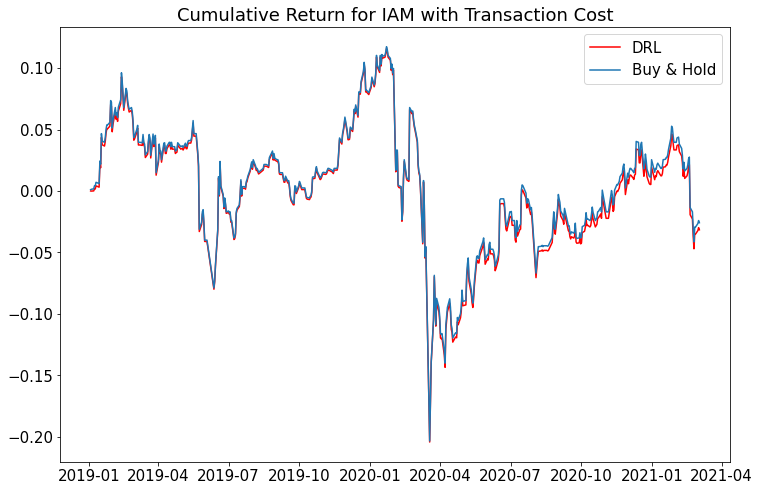

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for IAM with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)